## Setup and Configuration

In [ ]:
import json
from pathlib import Path
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np

from utils import (
    parse_output_types, get_optimal_resize_width,
    enumerate_aso_variants, name_filter, filter_by_strand,
    diff_mean, build_base_mask, collapse_ism, plot_all_outputs, find_exon_sequence
)
from alphagenome.models import dna_client
from alphagenome.data import genome, gene_annotation, transcript as transcript_utils
from alphagenome.visualization import plot_components

# Load config
config_name = 'SETD5_e2'  # Change config file here
with open(f'config_private/{config_name}.json', 'r', encoding='utf-8') as f:
    cfg = json.load(f)

cfg['results_dir'] = cfg['results_dir'] + '/ASO'
Path(cfg['data_dir']).mkdir(parents=True, exist_ok=True)
Path(cfg['results_dir']).mkdir(parents=True, exist_ok=True)
Path(f"{cfg['results_dir']}/{cfg['gene_symbol'].lower()}").mkdir(parents=True, exist_ok=True)

# Initialize model and annotations
model = dna_client.create(cfg['dna_api_key'])
gtf = pd.read_feather(cfg['gtf_url'])
gene_interval = gene_annotation.get_gene_interval(gtf, gene_symbol=cfg['gene_symbol'])

# Resize interval
config_resize = cfg.get('resize_width')
optimal_resize = get_optimal_resize_width(gene_interval.width, config_resize)
interval = gene_interval.resize(optimal_resize)

print(f"Gene: {cfg['gene_symbol']}")
print(f"Interval width: {gene_interval.width:,} bp | Resize: {optimal_resize:,} bp")

# Requested outputs
requested_outputs = parse_output_types(cfg.get('requested_outputs', ['RNA_SEQ', 'SPLICE_SITE_USAGE']))
print(f"Requested: {[ot.name for ot in requested_outputs]}")

# Transcripts
transcripts_df = gene_annotation.filter_to_mane_select_transcript(gene_annotation.filter_protein_coding(gtf))
transcripts = transcript_utils.TranscriptExtractor(transcripts_df).extract(gene_annotation.get_gene_interval(gtf, gene_symbol=cfg['gene_symbol']))

# Reference sequence
ref_seq = str(SeqIO.to_dict(SeqIO.parse(cfg['fasta_path'], 'fasta'))[interval.chromosome].seq[interval.start:interval.end])

# Exon interval (explicit)
target_interval = genome.Interval(
    chromosome=interval.chromosome,
    start=cfg['exon_intervals'][0],
    end=cfg['exon_intervals'][1],
    strand=interval.strand
)
exon_start_rel, exon_end_rel = find_exon_sequence(interval.start, cfg['exon_intervals'])
exon_start = interval.start + exon_start_rel
exon_end = interval.start + exon_end_rel
print(f"Target exon: {exon_start}-{exon_end}")

# Flank sanity
exon_length = exon_end - exon_start
min_flank = 100
if cfg['flank'] < min_flank:
    cfg['flank'] = min_flank
    print(f"Adjusted flank to {min_flank})")
cfg['flank'] += exon_length

Gene: SETD5
Interval width: 81,626 bp | Resize: 131,072 bp
Requested: ['RNA_SEQ', 'SPLICE_SITE_USAGE']
Target exon: 9433369-9433562


## Step 1: Interval Prediction and Visualization

In [21]:
# Interval prediction
ref_output = model.predict_interval(
    interval=interval,
    requested_outputs=requested_outputs,
    ontology_terms=cfg['ontology_terms'],
)


# Summary
for output_type in requested_outputs:
    track_data = ref_output.get(output_type)
    if track_data is not None and hasattr(track_data, 'values'):
        print(f"{output_type.name}: {track_data.values.shape} | {len(track_data.names)} tracks")

KeyboardInterrupt: 

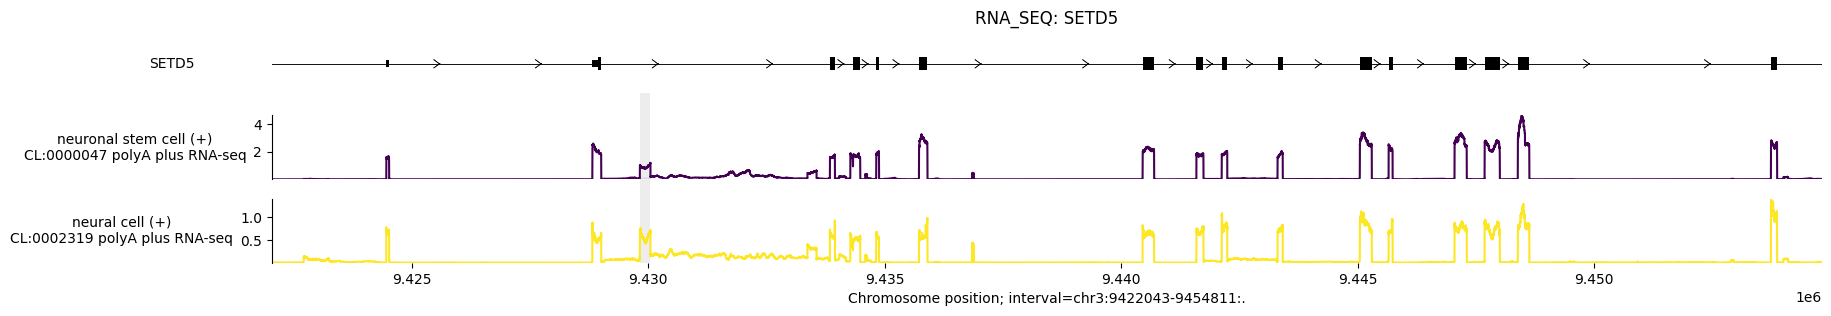

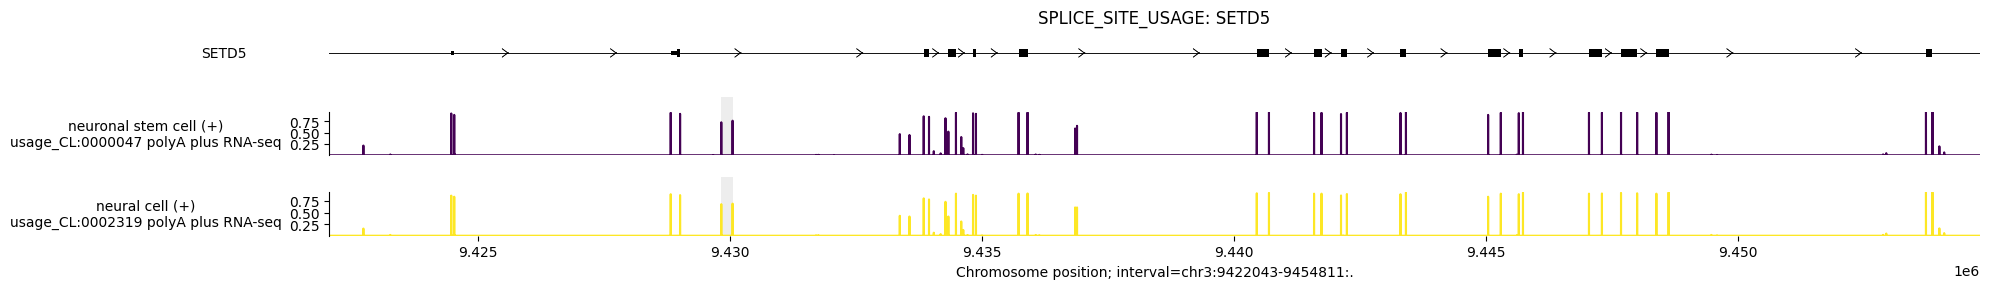

In [ ]:
# Visualize predictions
viz_width = cfg.get('viz_resize_width', 2**15)
plot_all_outputs(ref_output, transcripts, requested_outputs, cfg, resize_width=viz_width, target_interval=[target_interval])

## Step 2: ASO Masking Experiments

In [ ]:
# ASO variant window
from alphagenome.data.genome import Interval

variant_interval = Interval(
    chromosome=interval.chromosome,
    start=exon_start,
    end=exon_end,
).resize(cfg['flank'])

if cfg['flank'] > 1000:
    print(f"Warning: large flank {cfg['flank']} bp may use high memory.")

start_rel = variant_interval.start - interval.start
end_rel = variant_interval.end - interval.start
aso_length = cfg['ASO_length']
variants, asos = enumerate_aso_variants(ref_seq, start_rel, end_rel, aso_length)
print(f"ASO variants: {len(variants)} | length={aso_length} | window={variant_interval.start}-{variant_interval.end}")

ASO variants: 425 | length=18 | window=9429726-9430151


In [ ]:
# Predict masked sequences
outputs = model.predict_sequences(
    intervals=[interval] * len(variants),
    sequences=variants,
    requested_outputs=requested_outputs,
    ontology_terms=cfg['ontology_terms']
)
print(f"Predictions complete: {len(outputs)} sequences")

  0%|          | 0/425 [00:00<?, ?it/s]

100%|██████████| 425/425 [01:04<00:00,  6.61it/s]

Predictions complete: 425 sequences


In [ ]:
# ASO scoring and logos
track_pattern = cfg.get('track_filter', '')
start = exon_start - interval.start
end = exon_end - interval.start
plots = []
results = pd.DataFrame(asos, columns=['ASO_sequence'])

ref_subseq = str(SeqIO.to_dict(SeqIO.parse(cfg['fasta_path'], 'fasta'))[interval.chromosome].seq[variant_interval.start:variant_interval.end])
mask = build_base_mask(ref_subseq)

for output_type in requested_outputs:
    variant_array = []
    for i in range(len(outputs)):
        td = outputs[i].get(output_type)
        if td is None:
            continue
        if track_pattern:
            td = td.filter_tracks(name_filter(td.names, track_pattern))
        if 'strand' in cfg:
            td = filter_by_strand(td, cfg['strand'])
        variant_array.append(td.values.mean(axis=1))

    if not variant_array:
        print(f"Skipping {output_type.name}: no variant tracks")
        continue

    variant_array = np.stack(variant_array, axis=1)

    ref_td = ref_output.get(output_type)
    if ref_td is None:
        print(f"Skipping {output_type.name}: missing reference output")
        continue
    if cfg.get('track_filter'):
        ref_td = ref_td.filter_tracks(name_filter(ref_td.names, cfg['track_filter']))
    if 'strand' in cfg:
        ref_td = filter_by_strand(ref_td, cfg['strand'])

    ref_values = ref_td.values.mean(axis=1)[:, None]

    aso_scores = diff_mean(ref_values, variant_array, start, end)[:, None]
    collapsed = collapse_ism(aso_scores, mask)
    results[f'ASO_{output_type.name}'] = aso_scores.sum(1)

    ylabel = f"{output_type.name.lower()}"
    plots.append(plot_components.SeqLogo(scores=collapsed, scores_interval=variant_interval, ylabel=ylabel, max_width=cfg['flank']))

results.to_csv(f"{cfg['results_dir']}/{config_name}_ASO_scores.csv", index=False)
print(results.head())

         ASO_sequence  ASO_RNA_SEQ  ASO_SPLICE_SITE_USAGE
0  TTGTATCCCTTCTCTTTT    -0.010924               0.000026
1  TGTATCCCTTCTCTTTTA    -0.016198              -0.000018
2  GTATCCCTTCTCTTTTAA     0.008715               0.000105
3  TATCCCTTCTCTTTTAAG     0.013268               0.000070
4  ATCCCTTCTCTTTTAAGT     0.023247               0.000105


## Step 3: ASO Effect Scoring and Visualization

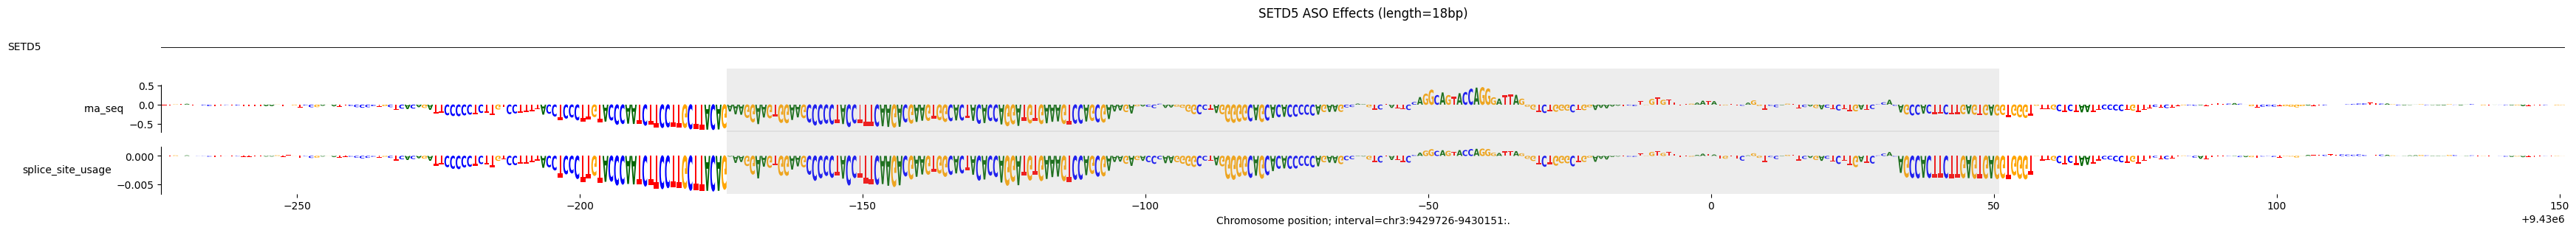

In [ ]:
plot_components.plot(
    [plot_components.TranscriptAnnotation(transcripts)] + plots,
    interval=variant_interval,
    fig_width=variant_interval.width // 10,
    title=f"{cfg['gene_symbol']} ASO Effects (length={cfg['ASO_length']}bp)",
    annotations=[plot_components.IntervalAnnotation([target_interval])]
)
plt.show()